# Mode-Turbulence Coupling: Numerical Analysis

In [19]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from scipy import integrate
import random
from scipy.integrate import quad
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import math
import scipy.interpolate as interpolate

## Variables

In [20]:
n_bins=40
#n_samples is the number of eddie turnovers
n_samples=80

Tr =2*np.pi

#variables for generating F1
meanF1 = 0
stdF1 =.3

#variables for generating F2

stdF2 =.09
meanF2=0

#initial conditions A(0)=0, dA/dT(0)=0

dAdT=0
AT=0


## Functions

In [21]:
def rayleighdistribution():

    rayleigh = np.random.rayleigh(2*np.pi, 1000)
    count, bins, ignored = plt.hist(rayleigh, 80, density=True)
    plt.title("Rayleigh Distribution")
    plt.xlabel("Delta T")
    plt.show()
    
# Source: https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.rayleigh.html

def fundeltaT(n_bins, n_samples):
    rayleigh = np.random.rayleigh(2*np.pi, 1000)                           
    hist, bin_edges = np.histogram(rayleigh, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    r = np.random.rand(n_samples)
    deltaT=inv_cdf(r)
    return deltaT

# Source: https://tmramalho.github.io/blog/2013/12/16/how-to-do-inverse-transformation-sampling-in-scipy-and-numpy/

# Tturb adds up the delta T's

def funTturb():
    Tturb=[0]
    for i in range(len(deltaT)-1):
        Tturb.append(deltaT[i]+Tturb[i])
    return Tturb

# t is the sum of half way points of consecutive delta T's

def funt():
    t=[]
    for i in range(len(deltaT)-1):
        t.append((deltaT[i])/2+(deltaT[i+1])/2)
    return t

def funF1(meanF1, stdF1, Tr):

    y1=.1
    F1=[]
    prob=[]

    for i in range(len(t)):
        arr=[]
        a=t[i]
        stdevt=((1-math.exp(-2*a/Tr))*stdF1**2)**(1/2)
        meant=math.exp(-a/Tr)*y1
        R=random.uniform(0,1)
        F1.append(meant-stdevt+2*stdevt*R)
    return F1

def funF2(meanF2, stdF2, Tr):

    y1=.01
    F2=[]

    for i in range(len(t)):
        arr=[]
        a=t[i]
        stdevt=((1-math.exp(-2*a/Tr))*stdF2**2)**(1/2)
        meant=math.exp(-a/Tr)*y1
        R=random.uniform(0,1)
        F2.append(meant-stdevt+2*stdevt*R)
    return F2

#To Generate G1, I take the derivative of F1 by taking the difference of F1 values at times halfway between consecutive delta T's and divide that by the difference in those times

def funG1():

    G1=[0]
    for i in range(len(F1)-1):
        G1.append((F1[i+1]-F1[i])/(deltaT[i]+deltaT[i+1]))
    return G1

#F2=constant=c
#1+G1=constant=b
#F1=constant=a

def funAmp(dAdT, AT):

    A=[]
    t=[]
    derivA=[]
    ## a**2<4*b is always the case
    for i in range(len(Tturb)-1):
        a=F1[i]
        b=G1[i]+1
        c=F2[i]
        Ttemp=np.linspace(Tturb[i], Tturb[i+1])
        q=1/2*(4*b-a**2)**(1/2)
        C0=(math.exp(a*Tturb[i]/2)*dAdT+(a/2+q*math.tan(q*Tturb[i]))*(AT-c/b)*(math.exp(a*Tturb[i]/2)))*(math.cos(q*Tturb[i])/q)
        C1=(AT-c/b)*math.exp(a*Tturb[i]/2)/math.cos(q*Tturb[i])-C0*math.tan(q*Tturb[i])
        for j in Ttemp:
            if j==Tturb[i]:
                pass
            else:
                t.append(j)
                A.append(math.exp(-a*j/2)*(C0*math.sin(q*j)+C1*math.cos(q*j))+c/b)
                derivA.append(math.exp(-a*j/2)*(-a/2*(C0*math.sin(q*j)+C1*math.cos(q*j))+q*C0*math.cos(q*j)-q*C1*math.sin(q*j)))
        dAdT=derivA[-1]
        AT=A[-1]
    
    return A, t

In [22]:
def FunavgA(A):
    Asqr=[]
    for i in A:
        Asqr.append(i**2)
    avg=sum(Asqr)/len(Asqr)
    return avg

def FunLog(A):
    logA=[]
    for i in A:
        logA.append(math.log10(abs(i)))
    return logA

## Outputs

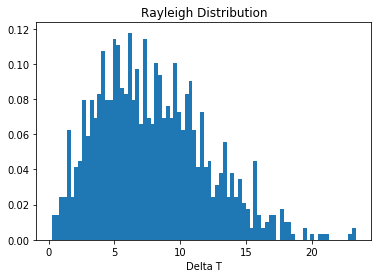

delta T values are:  [ 8.66516294  3.67594289  6.11120121  9.36088734 10.67686259  3.89272904
  4.81395981  2.41049034  4.91675119  5.9614785  12.97558613  7.15026298
 13.69981042  6.31075299 14.80226282  4.95427076 10.42975183  9.30154419
  6.61131546  8.95247707  6.6436705   6.90965169  5.70454211  5.79624748
  4.204761    2.55666122  5.13790466  7.14594286  5.85938652  3.96270066
  7.48986269  1.73958336  9.89420444 11.86772874  8.61488558  8.13641795
  9.44456306  5.91846948  1.6733939   4.49862025  5.40879877  8.51816473
  4.35848093  6.34070079  5.93833291 12.84893485 11.43988532 17.110902
  7.98660536  5.41734647  2.10101993  4.26516343 11.86215762 20.26421102
 11.86912175  1.97917481 13.41758483 15.73693473  3.83317877  7.47897759
  9.58360694  4.70817168  3.23632481 10.35415979 10.5627969  12.86661174
  0.13054632 16.06557978  7.25216325  3.76501491 11.20504556  3.26241945
 11.45086611 11.11249801 13.33033463  4.05817373  8.06001581  3.20594829
 11.93080805  9.02500599]

 Ttur

In [23]:
rayleighdistribution()

deltaT=fundeltaT(n_bins, n_samples)
print("delta T values are: ", deltaT)


Tturb=funTturb()
print("\n Tturb values are:", Tturb)

t=funt()
print("\n t values are:", t)

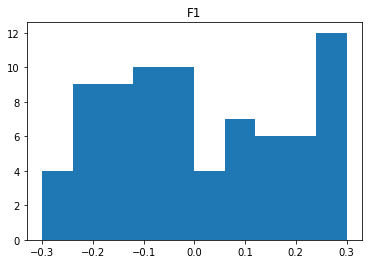

F1 values are [-0.03016897689981013, -0.05890825965069993, 0.1605873545925831, 0.24132968237947877, 0.3010786929218936, 0.11634290620014809, -0.18623847787762507, 0.24863961511937516, -0.13759805652929868, -0.1425906412655699, -0.054384063325171345, -0.12329335045409806, -0.09862063432748133, -0.2490575811610454, 0.1851019065896462, 0.06998137574758367, 0.24039960691802847, -0.24601913157413277, -0.028156250854528858, 0.28809135238094463, -0.0793108042595777, -0.05106592727721532, 0.16410257231188805, 0.2965924590710092, 0.040041521493475535, 0.2762238883481215, 0.00036699292494654645, 0.3035191516511175, -0.15518083633790875, -0.22685569675632336, 0.29059538069699375, -0.20307006282554704, -0.08910674587697268, -0.27330501985930633, -0.24622195359600513, -0.23905991474810084, 0.10582097244599026, 0.07234853125860721, 0.05447292061475073, 0.22886687564631952, 0.2174446836136279, -0.17779558760076436, -0.011382496478189563, 0.27752099346688114, 0.07707189088122685, -0.2141927619970798, 

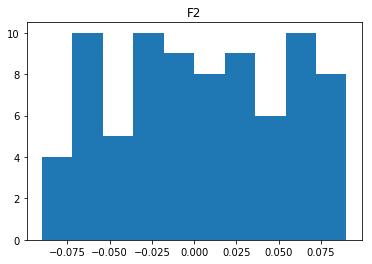

F2 values are [-0.024855592444198348, 0.08372831333328216, 0.08840743416979684, 0.06150737890557001, -0.0024230889456333393, 0.042075490131447485, -0.04081220085958296, -0.03460468050281666, 0.0015495292305657271, 0.06030786240686996, 0.015179244717969609, -0.0011220026082894158, 0.06755799439890331, -0.07150695648640967, -0.03581949857788374, 0.07489620852744626, -0.061514126841733296, 0.0840826583149345, 0.03503863640718237, 0.035155017977146166, -0.078410220300145, -0.03244106383904559, 0.06584453629749626, -0.05570248914961907, 0.024524238428904208, 0.06258901414568901, -0.006031223639838185, -0.0522777720962189, 0.03855082500612263, -0.007486502317399141, -0.002930398307713855, -0.01914952629067708, -0.020025455489669414, -0.0737920349665147, 0.0120093335543974, -0.08143785108812401, 0.032313755755333406, -0.016165560499687696, 0.07578151950492368, 0.04705855808402104, -0.06311875296828039, 0.049681479826693214, -0.07111330546386826, 0.026506046350431217, 0.07620954151165119, 0.05

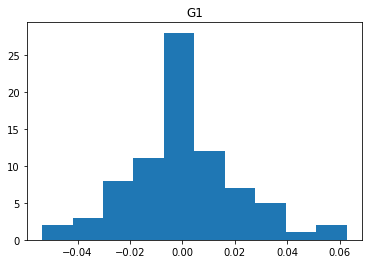

G1 values are  [0, -0.0023287445341513653, 0.022426931905568104, 0.005218579737481875, 0.0029818223485636223, -0.012679544590328337, -0.03475275034947041, 0.06019532059617747, -0.05271256174624047, -0.0004589519506872478, 0.004657880177372848, -0.003423919495196699, 0.0011833395329194486, -0.007517876619999827, 0.020563594122427694, -0.005826959998414006, 0.011077611864096169, -0.024652143366662566, 0.01369099492454466, 0.02031944352602722, -0.023557237779325585, 0.0020839818160738356, 0.01705764974679661, 0.011520068753289267, -0.025652506758536794, 0.034930870952621776, -0.03585087190352226, 0.024678925586093293, -0.035270155381333115, -0.007297314623864576, 0.04518211876552127, -0.053488090259471335, 0.009795890972310659, -0.008464242235746473, 0.0013222465568503462, 0.00042755113571429107, 0.019616703247708117, -0.002178765233861053, -0.0023545748593567033, 0.02825559870992272, -0.0011528927973361428, -0.028379500754350754, 0.01292363675780229, 0.027002391168242792, -0.016324501377

In [24]:
F1=funF1(meanF1, stdF1, Tr)
plt.hist(F1, 10, range=(-stdF1, stdF1))
plt.title("F1")
plt.show()
print("F1 values are", F1)

F2=funF2(meanF2, stdF2, Tr)
plt.hist(F2, 10, range=(-stdF2, stdF2))
plt.title("F2")
plt.show()
print("F2 values are", F2)

G1=funG1()
plt.hist(G1, 10)
plt.title("G1")
plt.show()
print("G1 values are ", G1)

### Amplitude of mode

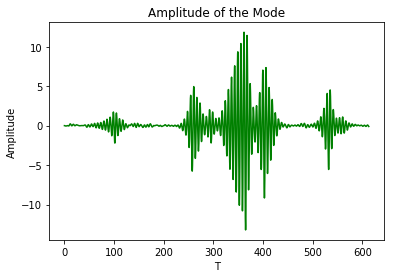

Amplitude of mode for 80 eddy turnovers

 Average value of the amplitude squared = 5.793397888352883


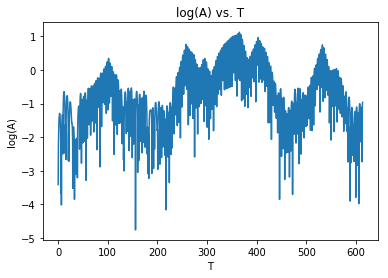

In [25]:
A, t =funAmp(dAdT, AT)
plt.plot(t, A, 'g')
plt.xlabel('T')
plt.ylabel('Amplitude')
plt.title('Amplitude of the Mode')
plt.show()

avg= FunavgA(A)

print("Amplitude of mode for" , n_samples, "eddy turnovers")
print("\n Average value of the amplitude squared =", avg)

logA=FunLog(A)

plt.plot(t,logA)
plt.xlabel('T')
plt.ylabel('log(A)')
plt.title('log(A) vs. T')
plt.show()

### Check that derivative is correct for the first three eddies

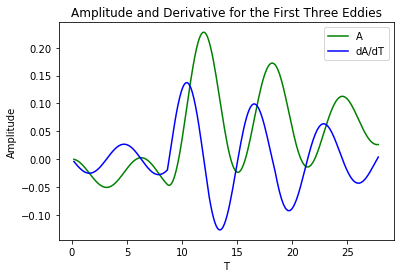

In [26]:
#FIRST EDDY TURNOVER
#check that derivative is correct

A=[]
t=[]
derivA=[]

dAdT=0
AT=0
## a**2<4*b is always the case
for i in range(4):
    a=F1[i]
    b=G1[i]+1
    c=F2[i]
    Ttemp=np.linspace(Tturb[i], Tturb[i+1])
    q=1/2*(4*b-a**2)**(1/2)
    C0=(math.exp(a*Tturb[i]/2)*dAdT+(a/2+q*math.tan(q*Tturb[i]))*(AT-c/b)*(math.exp(a*Tturb[i]/2)))*(math.cos(q*Tturb[i])/q)
    C1=(AT-c/b)*math.exp(a*Tturb[i]/2)/math.cos(q*Tturb[i])-C0*math.tan(q*Tturb[i])
    for j in Ttemp:
        if j==Tturb[i]:
            pass
        else:
            t.append(j)
            A.append(math.exp(-a*j/2)*(C0*math.sin(q*j)+C1*math.cos(q*j))+c/b)
            derivA.append(math.exp(-a*j/2)*(-a/2*(C0*math.sin(q*j)+C1*math.cos(q*j))+q*C0*math.cos(q*j)-q*C1*math.sin(q*j)))
    dAdT=derivA[-1]
    AT=A[-1]
    tend=t[-1]
    
plt.plot(t, A, 'g', label="A")
plt.plot(t, derivA, 'b', label="dA/dT")
plt.xlabel('T')
plt.ylabel('Amplitude')
plt.title('Amplitude and Derivative for the First Three Eddies')
plt.legend()